In [1]:
from typing import NamedTuple, Sequence

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform
from einops import rearrange, reduce
from pytorch3d.ops import interpolate_face_attributes
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer import  TexturesUV
from rendering import init_renderer, rasterize_mesh
import torchvision.transforms as transforms
from diffusion import depth2img_pipe, depth2img

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0")
meshes = load_objs_as_meshes(['data/cow_mesh/cow.obj'], device=device)

In [3]:
R, T = look_at_view_transform(dist=2, azim=150, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)

# Set up Renderer
renderer = init_renderer(cameras)

# Rasterize Mesh
fragments, depth_map = rasterize_mesh(renderer, meshes)

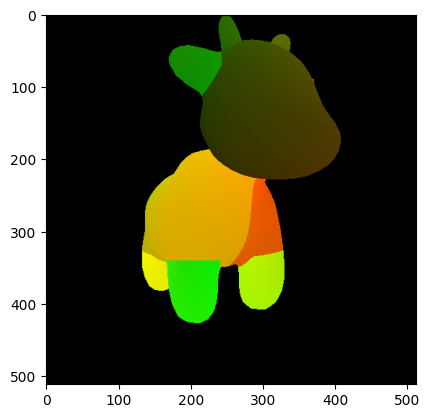

In [4]:
# get UV coordinates for each pixel
texture: TexturesUV = meshes.textures
texture_map = texture.maps_list()[0]
verts_uvs = texture.verts_uvs_list()[0]
faces_uvs = texture.faces_uvs_list()[0]

# (F, 3, 2) for each face, for each vert a uv coord
face_vert_uvs = verts_uvs[faces_uvs]

# interpolate uv coords to obtain pixel-uvs
pixel_uvs = interpolate_face_attributes(
    fragments.pix_to_face,
    fragments.bary_coords,
    face_vert_uvs
)

# (H, W, 2)
pixel_uvs = rearrange(pixel_uvs, '1 h w 1 d -> h w d')

# add empty channel to make it RGB for visualization purposes
pixel_uvs_rgb = torch.cat([pixel_uvs, torch.zeros(pixel_uvs.shape[0], pixel_uvs.shape[1], 1).to(pixel_uvs)], dim=2)
plt.imshow(pixel_uvs_rgb.cpu())

In [5]:
pipe = depth2img_pipe()

Loading pipeline components...:  67%|██████▋   | 4/6 [00:00<00:00,  4.46it/s]/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.68it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all publ

In [6]:
pipe = depth2img_pipe() 

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


100%|██████████| 30/30 [00:06<00:00,  4.54it/s]


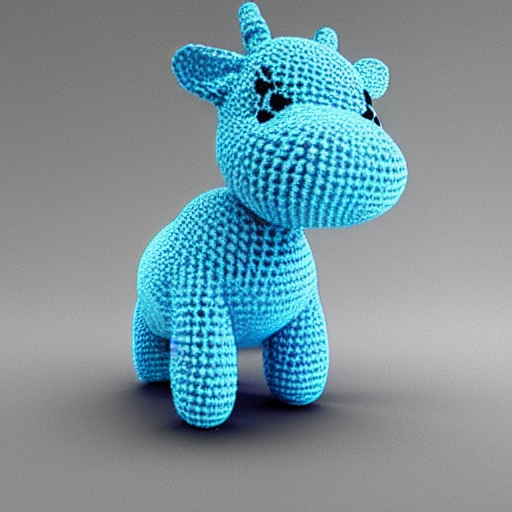

In [7]:
image = depth2img(
    pipe,
    'light blue toy Crochet cow',
    to_pil(depth_map)
)
image.save('data/example/view.png')
image

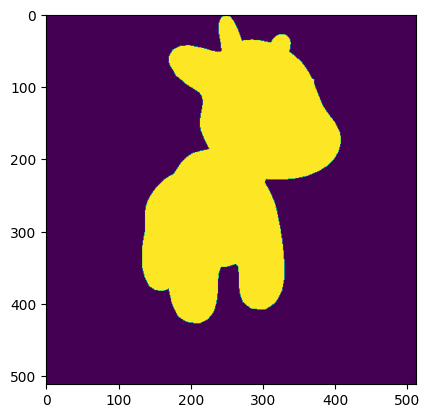

In [13]:
# values that 
mask = depth_map != 0
plt.imshow(mask.cpu())

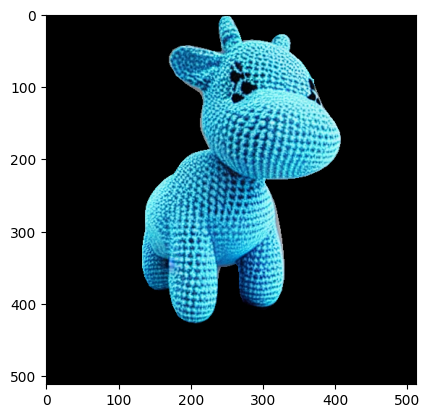

In [16]:
from util import swap_channel_pos

image_tensor = swap_channel_pos(to_tensor(image))

image_tensor[~mask] = 0

plt.imshow(image_tensor)

In [90]:
# uv coords of each pixel that is not masked
projected_uvs = pixel_uvs[mask]
indices = torch.nonzero(mask)

projected_uvs


tensor([[0.1645, 0.4226],
        [0.1652, 0.4233],
        [0.1656, 0.4243],
        ...,
        [0.1315, 0.9417],
        [0.1309, 0.9420],
        [0.1308, 0.9433]])

In [73]:
uv_size = 1024

y_values = (1 - projected_uvs[:, 1]) * (uv_size - 1)
x_values = projected_uvs[:, 0] * (uv_size - 1)

y_0 = torch.floor(y_values)
y_1 = torch.ceil(y_values)
x_0 = torch.floor(x_values)
x_1 = torch.ceil(x_values)

ys, xs = torch.cat([y_0, y_0, y_1, y_1], 0).long(), torch.cat([x_0, x_1, x_0, x_1], 0).long()

ys.shape


torch.Size([264596])

In [91]:
new_texture = texture_map.clone()

# texel coords of ach projected value
texture_coords = (projected_uvs*1024).to(int)

new_texture[ys, xs] = 0

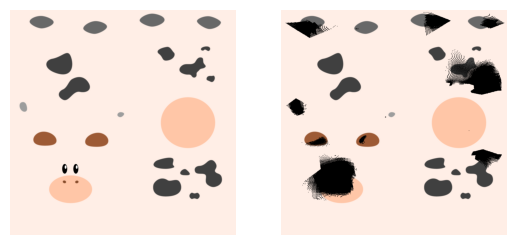

In [92]:
fig, axs = plt.subplots(1,2)

for ax in axs:
    ax.axis('off')

axs[0].imshow(texture_map.cpu())
axs[1].imshow(new_texture.cpu())
